In [12]:
from conch.open_clip_custom import create_model_from_pretrained, tokenize, get_tokenizer
import torch
import os
from PIL import Image
from pathlib import Path

# show all jupyter output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [13]:
root = Path('../').resolve()
os.chdir(root)

Load model from checkpoint

In [14]:
model_cfg = 'conch_ViT-B-16'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# checkpoint_path = 'checkpoints/CONCH/pytorch_model.bin'
checkpoint_path = 'C:\\Users\\Vivian\\Documents\\CONCH\\checkpoints\\conch\\pytorch_model.bin' 
model, preprocess = create_model_from_pretrained(model_cfg, checkpoint_path, device=device)
_ = model.eval()

Open an image and preprocess it

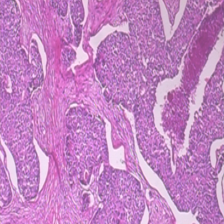

In [37]:
# image = Image.open('C:\\Users\\Vivian\\Documents\\CONCH\\docs\\roi1.jpg')
# image = Image.open(r"C:\Users\Vivian\Documents\breakhis\BreaKHis_v1\BreaKHis_v1\histology_slides\breast\benign\SOB\adenosis\SOB_B_A_14-22549AB\40X\SOB_B_A-14-22549AB-40-001.png") # sample benign image from breakhis
image = Image.open(r"C:\Users\Vivian\Documents\breakhis\BreaKHis_v1\BreaKHis_v1\histology_slides\breast\malignant\SOB\ductal_carcinoma\SOB_M_DC_14-2523\40X\SOB_M_DC-14-2523-40-010.png") # sample malignant image from breakhis
# image = Image.open(r"C:\Users\Vivian\Documents\FA 57B-image.tif")
image_tensor = preprocess(image).unsqueeze(0).to(device)
image.resize((224, 224))

Load tokenizer and specify some prompts. Simplicity we just use one prompt per class (lung adenocarcinoma vs. lung squamous cell carcinoma) here instead ensembling multiple prompts / prompt templates.

In [20]:
tokenizer = get_tokenizer()
classes = ['invasive ductal carcinoma', 
           'invasive lobular carcinoma']
prompts = ['an H&E image of invasive ductal carcinoma', 
           'an H&E image of invasive lobular carcinoma']

In [34]:
tokenizer = get_tokenizer()
classes = ['benign', 
           'malignant']
prompts = ['an H&E image of benign breast tumor', 
           'an H&E image of malignant breast tumor']

In [35]:
tokenized_prompts = tokenize(texts=prompts, tokenizer=tokenizer).to(device)
tokenized_prompts.shape

torch.Size([2, 128])

In [36]:
with torch.inference_mode():
    image_embedings = model.encode_image(image_tensor)
    text_embedings = model.encode_text(tokenized_prompts)
    sim_scores = (image_embedings @ text_embedings.T * model.logit_scale.exp()).softmax(dim=-1).cpu().numpy()

print("Predicted class:", classes[sim_scores.argmax()])
print("Normalized similarity scores:", [f"{cls}: {score:.3f}" for cls, score in zip(classes, sim_scores[0])])

Predicted class: benign
Normalized similarity scores: ['benign: 0.863', 'malignant: 0.137']
